In [248]:
import numpy as np
import pandas as pd
import os
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [249]:
#Cargando la data .npz correspondientes para el Training del modelo

train_img = np.load("../input/kuzushiji/kmnist-train-imgs.npz")["arr_0"]
label_train = np.load("../input/kuzushiji/kmnist-train-labels.npz")["arr_0"]


#Cargando la data .npz correspondientes para el Testing

testing_img = np.load("../input/kuzushiji/kmnist-test-imgs.npz")["arr_0"]
label_testing = np.load("../input/kuzushiji/kmnist-test-labels.npz")["arr_0"]

In [250]:
#Separando los datos
print("Antes:" ,train_img.shape)
train_img, test_img, label_train,label_test=train_test_split(train_img,label_train,test_size=0.20)
print("Entrenamiento: ", train_img.shape)
print("Validacion: ", test_img.shape)

Antes: (60000, 28, 28)
Entrenamiento:  (48000, 28, 28)
Validacion:  (12000, 28, 28)


In [251]:
def proceso_img(dataset,labels):
    """Como la mateamtica para las redes neuronales es continua, no discreta,
    y esto se aproxima meejor con numero puntos flotantes.Las entradas, salidas y
    y pesos de una red son numeros continuos. https://stackoverflow.com/questions/59986353/why-do-i-have-to-convert-uint8-into-float32"""
    
    new_data=dataset.astype('float32')
    new_data=new_data/255 #normalizamos pasando los valores a un rango entre 1 y 0
    new_data=np.reshape(new_data,(len(new_data,),1,28,28))
    new_labels=labels.astype('int64')
    return new_data, new_labels
    
train_img,label_train=proceso_img(train_img,label_train)
test_img,label_test=proceso_img(test_img,label_test)
#Se transforma el conjunto de datos en tensores
X_train_img=torch.Tensor(train_img)
""" Para operaciones entre tensores, la regla es estricta. 
Ambos tensores de la operación deben tener el mismo tipo de datos, o veremos mensajes de error
https://jdhao.github.io/2017/11/15/pytorch-datatype-note/ """
y_train_img=torch.Tensor(label_train).type(torch.LongTensor)
X_valid_img=torch.Tensor(test_img)
y_valid_img=torch.Tensor(label_test).type(torch.LongTensor)

print("Set de entrenamiento:  "+str(X_train_img.shape))
print("Etiquetas de entrenamiento:  "+str(y_train_img.shape))    
print("Set de validacion:  "+str(X_valid_img.shape)) 
print("Etiquetas de validacion :  "+str(y_valid_img.shape)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset = torch.utils.data.TensorDataset(X_train_img, y_train_img)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle = False)

valid_dataset = torch.utils.data.TensorDataset(X_valid_img, y_valid_img)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 400, shuffle = False)

Set de entrenamiento:  torch.Size([48000, 1, 28, 28])
Etiquetas de entrenamiento:  torch.Size([48000])
Set de validacion:  torch.Size([12000, 1, 28, 28])
Etiquetas de validacion :  torch.Size([12000])
cuda


In [252]:
class CNN(nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0), # output dim =(24*24*16)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)) # output dim = (12*12*16)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # output dim = (6*6*32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # output dim = (3*3*32)
            nn.Dropout(p=0.2)) 
        
        self.fc1 = nn.Sequential( 
             nn.Linear(288, 100),
             nn.ReLU(),
             nn.Linear(100,420 ),
             nn.ReLU(),
             nn.Linear(420,10),
             nn.LogSoftmax(dim=1)
             
            )
        
    def forward(self, x):
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        h2 = h2.view(h2.size(0), -1)
        h3 = self.fc1(h2)
        return h3

In [253]:
model=CNN()
criterion=nn.CrossEntropyLoss()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs=30
training_loss=[]
valid_loss=[]
training_accuracy=[]
valid_accuracy=[]

In [254]:
for epoch in range (epochs):
    """ model.train() estabelce los modulos en la red en modo de entrenamiento.
    Es decir, le comenta a nuestro modelo que estamos en la fase de entrenamiento, 
    por lo que el modelo mantiene activa algunas capas."""
    model.train() 
    running_loss=0
    accuracy=0
    steps=0
    
    for i, (images, labels) in enumerate(trainloader):
        images=images.cuda()
        labels=labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        optimizer.zero_grad()
        """ necesitamos establecer los gradientes en cero antes de comenzar
        a hacer la propagación hacia atrás porque PyTorch acumula los gradientes
        en las pasadas posteriores hacia atrás. Por eso se apliza zer.grad() """
        
        loss.backward() #calcula la derivada de la pérdida w.r.t. los parámetros (o cualquier cosa que requiera gradientes) usando retropropagación.
        optimizer.step() #hace que el optimizador dé un paso basado en los gradientes de los parámetros.
        
        running_loss += loss.item() #El método extrae el valor de la pérdida como un flotante de Python
        
        _, predicted = torch.max(output, 1)
        accuracy += (predicted == labels).sum()
        steps += 1
        
    training_loss.append(running_loss/steps)
    training_accuracy.append(100 * accuracy.cpu().numpy()/len(train_dataset))
    model.eval()
    with torch.no_grad():
        iter_loss = 0
        accuracy = 0
        steps = 0
    
        for i, (images, labels) in enumerate(validloader):
            images=images.cuda()
            labels=labels.cuda()
            output = model(images)
            loss = criterion(output, labels)
        
            iter_loss += loss.item()
            _, predicted = torch.max(output, 1)
            accuracy += (predicted == labels).sum()
            steps += 1
            
        valid_loss.append(iter_loss/steps)
        valid_accuracy.append(100 * accuracy.cpu().numpy()/len(valid_dataset))
                
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.2f}%, Validation Loss: {:.3f}, Validation Acc: {:.2f}%'
            .format(epoch+1, epochs, training_loss[-1], training_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

Epoch 1/30, Training Loss: 0.562, Training Accuracy: 82.22%, Validation Loss: 0.220, Validation Acc: 93.17%
Epoch 2/30, Training Loss: 0.185, Training Accuracy: 94.26%, Validation Loss: 0.114, Validation Acc: 96.61%
Epoch 3/30, Training Loss: 0.119, Training Accuracy: 96.29%, Validation Loss: 0.124, Validation Acc: 96.17%
Epoch 4/30, Training Loss: 0.094, Training Accuracy: 97.09%, Validation Loss: 0.089, Validation Acc: 97.30%
Epoch 5/30, Training Loss: 0.078, Training Accuracy: 97.46%, Validation Loss: 0.096, Validation Acc: 97.18%
Epoch 6/30, Training Loss: 0.069, Training Accuracy: 97.75%, Validation Loss: 0.074, Validation Acc: 97.83%
Epoch 7/30, Training Loss: 0.060, Training Accuracy: 98.06%, Validation Loss: 0.061, Validation Acc: 98.17%
Epoch 8/30, Training Loss: 0.054, Training Accuracy: 98.29%, Validation Loss: 0.072, Validation Acc: 97.92%
Epoch 9/30, Training Loss: 0.049, Training Accuracy: 98.43%, Validation Loss: 0.063, Validation Acc: 98.09%
Epoch 10/30, Training Loss: 

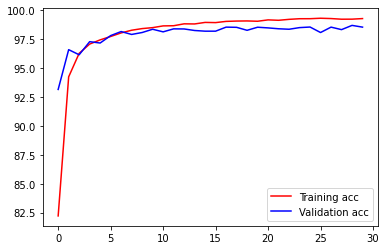

In [255]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_accuracy, color='red', label="Training acc")
plt.plot(valid_accuracy, color='blue',label="Validation acc")
plt.legend()
plt.show()

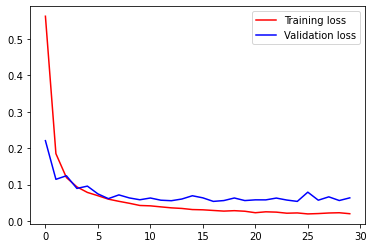

In [256]:
plt.plot(training_loss, color='red', label="Training loss")
plt.plot(valid_loss, color='blue',label="Validation loss")
plt.legend()
plt.show()

In [259]:
testing_img=np.load("../input/kuzushiji/kmnist-test-imgs.npz")["arr_0"]
label_testing=np.load("../input/kuzushiji/kmnist-test-labels.npz")["arr_0"]


new_testing_img,new_testing_label=proceso_img(testing_img,label_testing)
X_testing=torch.Tensor(new_testing_img)
y_testing=torch.Tensor(new_testing_label).type(torch.LongTensor)

print('test data shape' +str(X_testing.shape))
print('test labels shape' +str(y_testing.shape))

test_dataset = torch.utils.data.TensorDataset(X_testing, y_testing)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 300, shuffle=False)

test data shapetorch.Size([10000, 1, 28, 28])
test labels shapetorch.Size([10000])


In [261]:
model.eval()

with torch.no_grad():
    accuracy = 0
    total = 0
    test_loss = 0
    
    for images, labels in testloader:
        images=images.cuda()
        labels=labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_loss = test_loss/len(testloader)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        test_accuracy = (100*accuracy)/total
    print('Test Loss: {:.3f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.004, Test Accuracy: 95.75%
